In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
import numpy as np

from utils import calibration_curve, ece, mce, mce_rel

# Load and prepare data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/zunicd/Bank-Churn-Prediction/master/Resources/Churn_Modelling.csv", header=0, sep=",")

In [3]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

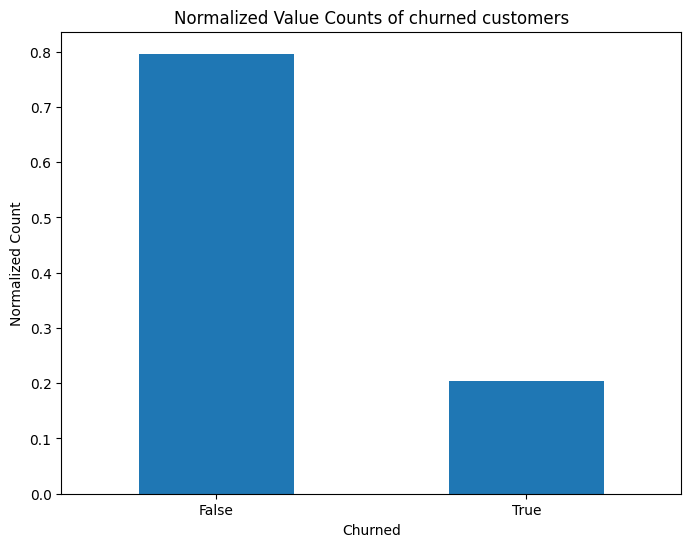

In [4]:
value_counts_normalized = df['Exited'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
ax = value_counts_normalized.plot(kind='bar')
plt.title('Normalized Value Counts of churned customers')
plt.xlabel('Churned')
plt.ylabel('Normalized Count')

plt.gca().set_facecolor('white')
ax.set_xticklabels(['False', 'True'],rotation=0)
plt.show()

In [5]:
df.drop("RowNumber", axis=1, inplace=True)

In [6]:
df.shape

(10000, 13)

In [7]:
TARGET = "Exited"

y = df.pop(TARGET)
X = df

In [8]:
df.drop(columns=["CustomerId"], axis=1, inplace=True)

### Prepare preprocessor

In [9]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=0)
si = SimpleImputer(strategy="mean", add_indicator=False)
categoricals = df.select_dtypes("object").columns.to_list()
numericals = df.select_dtypes("int64").columns.to_list()

le = LabelEncoder()

preprocessor = make_column_transformer(
    (si, numericals),
    (oe, categoricals)
)

### Apply preprocessor

In [10]:
preprocessor.set_output(transform="pandas")

new_X = preprocessor.fit_transform(X=X)
new_y = le.fit_transform(y)

### Train Test Val Split

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(new_X, new_y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# A simple RF model

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = RandomForestClassifier()

In [34]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
y_prob = clf.predict_proba(X_val)[:,1]

In [36]:
y_prob

array([0.16, 0.  , 0.2 , ..., 0.17, 0.77, 0.03])

In [37]:
y_prob.mean()

0.20718999999999999

## Plot the calibration curve

Note that one can plot the calibration curve via 

* ```python
  CalibrationDisplay.from_estimator()
  ```
* ```python
  CalibrationDisplay.from_predictions()
  ```
or
* ```python
  prob_true, prob_pred, weights = calibration_curve()
  CalibrationDisplay(prob_true, prob_pred, y_val).plot(ax=ax, label="RF")
  ```

Note that calibration_curve might crash if bins are equal. A solution is provided within the utils.

### Equidistant Bins

In [40]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

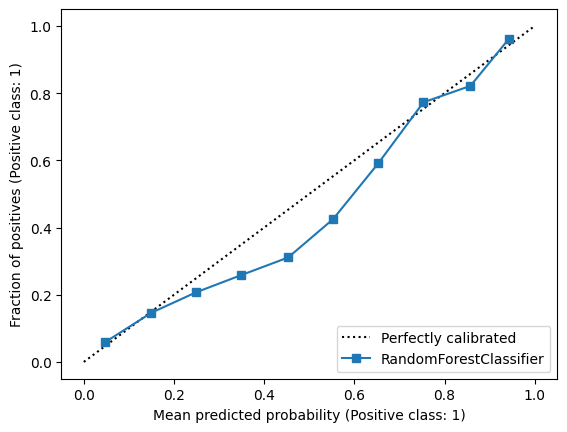

In [41]:
display = CalibrationDisplay.from_estimator(
    clf,
    X_val,
    y_val,
    n_bins=10,
)
plt.show()

### Bins based on quantiles

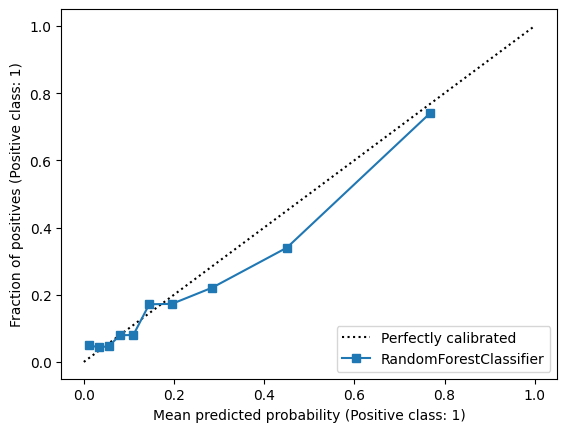

In [42]:
display = CalibrationDisplay.from_estimator(
    clf,
    X_val,
    y_val,
    n_bins=10,
    strategy="quantile"
)
plt.show()

## Calibration Metrics

In [43]:
y_prob = clf.predict_proba(X_val)[:,1]

prob_true, prob_pred, weights = calibration_curve(y_true=y_val, 
                                                  y_prob=y_prob, 
                                                  n_bins=10, 
                                                  strategy='quantile')

In [44]:
fraction_of_positives = prob_true
mean_predicted_value = prob_pred

ece_score = round(ece(fraction_of_positives, mean_predicted_value, weights), 2)
mce_score = round(mce(fraction_of_positives, mean_predicted_value), 2)
mce_rel_score = round(mce_rel(fraction_of_positives, mean_predicted_value), 2)

{"ece": ece_score, 
"mce": mce_score, 
"mce_rel": mce_rel_score,
 }

{'ece': 3.05, 'mce': 11.41, 'mce_rel': 10.54}

## Calibrate

In [45]:
from sklearn.calibration import CalibratedClassifierCV

In [46]:
cal_clf = CalibratedClassifierCV(estimator=clf, cv=5, method="isotonic")
cal_clf.fit(X=X_test, y=y_test)
cal_y_proba = cal_clf.predict_proba(X_val)[:,1]

## Compare

### Plot

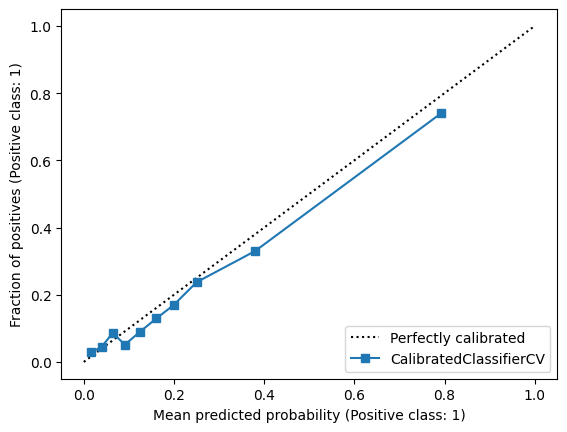

In [47]:
display = CalibrationDisplay.from_estimator(
    cal_clf,
    X_val,
    y_val,
    n_bins=10,
    strategy="quantile"
)
plt.show()

### Metrics

In [49]:
y_prob = cal_clf.predict_proba(X_val)[:,1]

prob_true, prob_pred, weights = calibration_curve(y_true=y_val, 
                                                  y_prob=y_prob, 
                                                  n_bins=10, 
                                                  strategy='quantile')

In [50]:
fraction_of_positives = prob_true
mean_predicted_value = prob_pred

ece_score = round(ece(fraction_of_positives, mean_predicted_value, weights), 2)
mce_score = round(mce(fraction_of_positives, mean_predicted_value), 2)
mce_rel_score = round(mce_rel(fraction_of_positives, mean_predicted_value), 2)

{"ece": ece_score, 
"mce": mce_score, 
"mce_rel": mce_rel_score,
}

{'ece': 2.73, 'mce': 5.23, 'mce_rel': 1.09}

# More model architectures

In [52]:
import numpy as np

from sklearn.svm import LinearSVC

class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [53]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

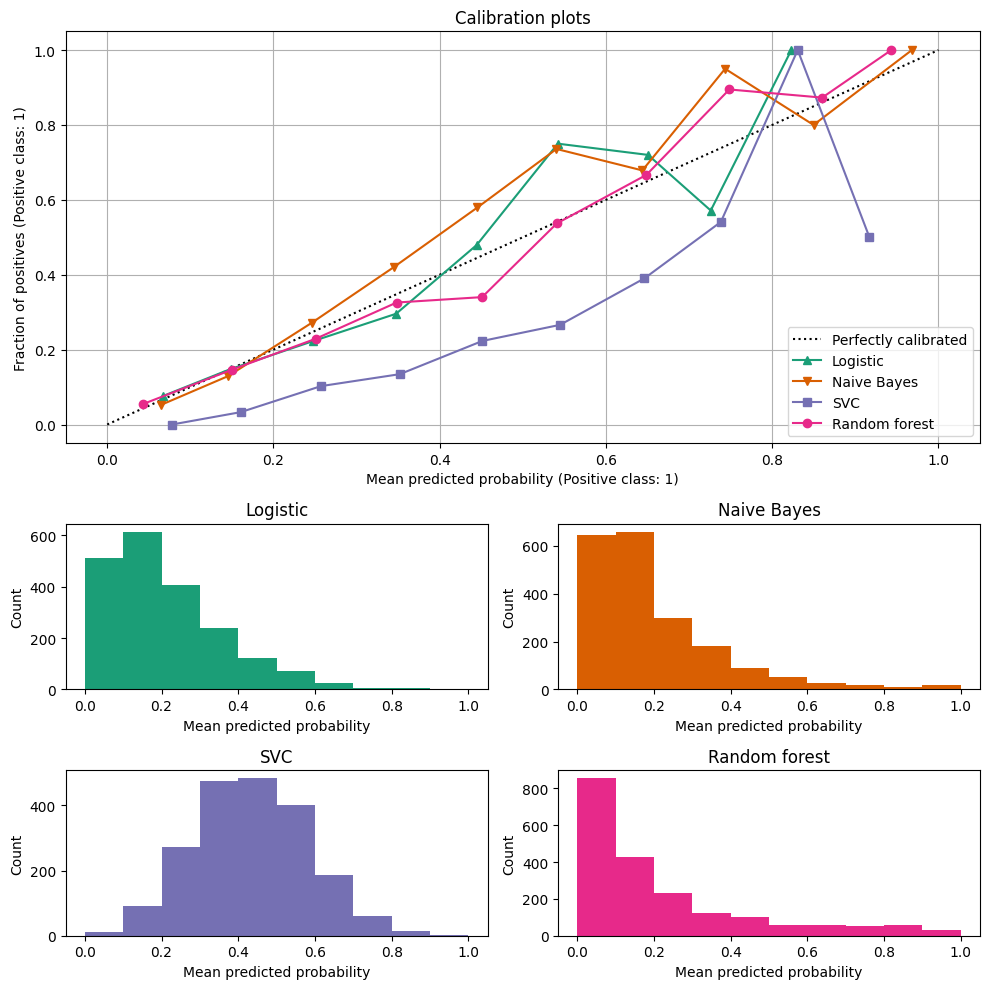

In [55]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Calculate metrics

In [57]:
clf_baseline = dict()
for clf, name in clf_list:
    clf_baseline[name] = clf

y_proba = {}
for name, clf in clf_baseline.items():
    y_proba[name] = clf_baseline[name].predict_proba(X_val)[:,1]

cal_curve = {}
for name, clf in clf_baseline.items():
    prob_true, prob_pred, weights = calibration_curve(y_true=y_val, 
                                                      y_prob=y_proba[name], 
                                                      n_bins=10, strategy='quantile')
    cal_curve[name] = prob_true, prob_pred, weights

scores = {}
for name, (prob_true, prob_pred, weights) in cal_curve.items():
    fraction_of_positives = prob_true
    mean_predicted_value = prob_pred

    ece_score = round(ece(fraction_of_positives, mean_predicted_value, weights), 2)
    mce_score = round(mce(fraction_of_positives, mean_predicted_value), 2)
    mce_rel_score = round(mce_rel(fraction_of_positives, mean_predicted_value), 2)

    scores[name] = {"ece": ece_score, 
                    "mce": mce_score, 
                    "mce_rel": mce_rel_score,
                    }

In [58]:
scores

{'Logistic': {'ece': 2.94, 'mce': 8.14, 'mce_rel': 0.33},
 'Naive Bayes': {'ece': 2.27, 'mce': 5.19, 'mce_rel': 0.37},
 'SVC': {'ece': 24.42, 'mce': 35.6, 'mce_rel': 0.67},
 'Random forest': {'ece': 3.5, 'mce': 9.02, 'mce_rel': 4.17}}

## Calibrate

In [59]:
%%capture
import warnings
warnings.filterwarnings('ignore')

cal_clf = {}
cal_y_proba = {}
for clf, name in clf_list:
    cal_clf[name] = CalibratedClassifierCV(estimator=clf, cv=5, method="isotonic")
    cal_clf[name].fit(X=X_test, y=y_test)
    cal_y_proba[name] = cal_clf[name].predict_proba(X_val)[:,1]

In [60]:
cal_curve = {}
for name,clf in cal_clf.items():
    prob_true, prob_pred, weights = calibration_curve(y_true=y_val, y_prob=cal_y_proba[name], n_bins=10, strategy='quantile')
    cal_curve[name] = prob_true, prob_pred, weights

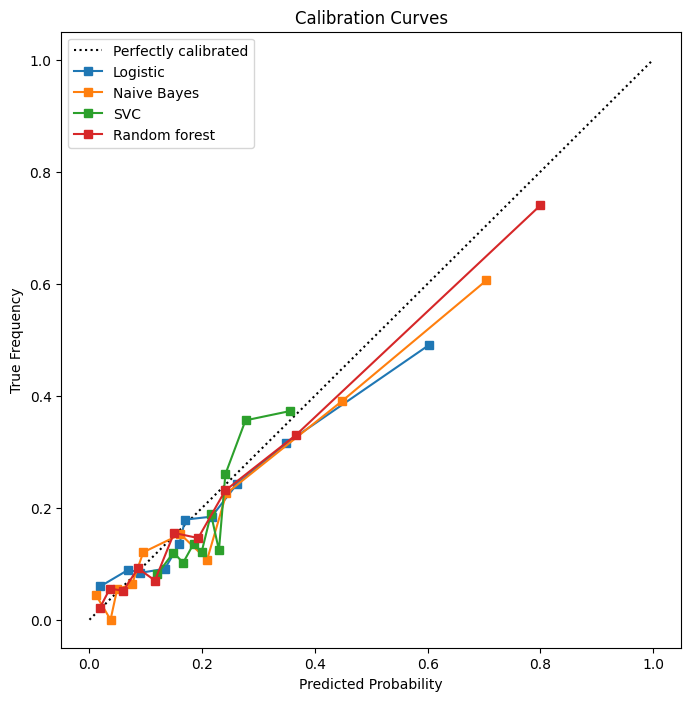

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

for name, (prob_true, prob_pred, weights) in cal_curve.items():
    CalibrationDisplay(prob_true, prob_pred, y_val).plot(ax=ax, label=name)

ax.set_title('Calibration Curves')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('True Frequency')

ax.legend()
plt.show()

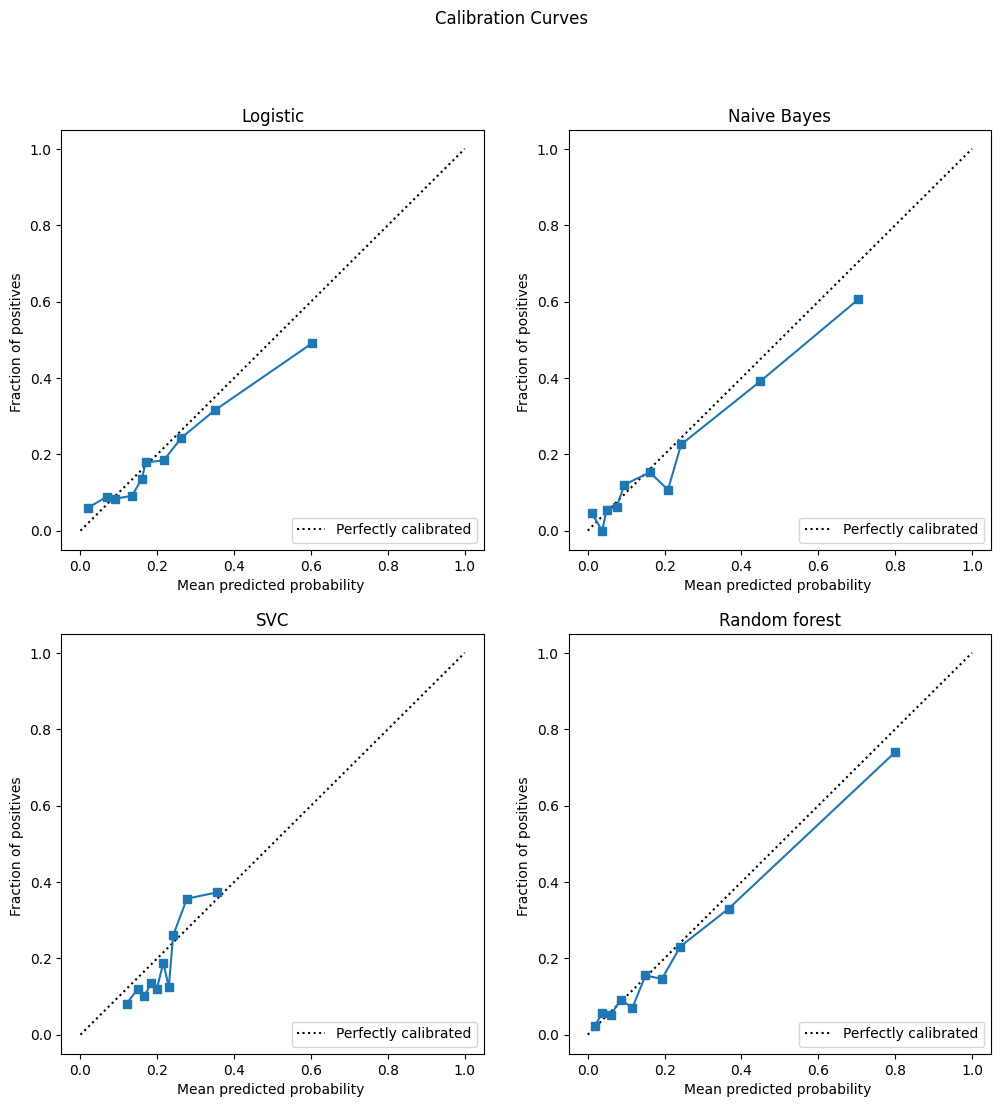

In [62]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    name, (prob_true, prob_pred, weights) = list(cal_curve.items())[i]
    CalibrationDisplay(prob_true, prob_pred, y_val).plot(ax=ax)
    ax.set_title(name)

fig.suptitle('Calibration Curves')
plt.show()

## Calculate metrics again

In [63]:
scores = {}
for name, (prob_true, prob_pred, weights) in cal_curve.items():
    fraction_of_positives = prob_true
    mean_predicted_value = prob_pred

    ece_score = round(ece(fraction_of_positives, mean_predicted_value, weights), 2)
    mce_score = round(mce(fraction_of_positives, mean_predicted_value), 2)
    mce_rel_score = round(mce_rel(fraction_of_positives, mean_predicted_value), 2)

    scores[name] = {"ece": ece_score, 
                    "mce": mce_score, 
                    "mce_rel": mce_rel_score,
                    }

In [64]:
scores

{'Logistic': {'ece': 3.45, 'mce': 11.17, 'mce_rel': 2.12},
 'Naive Bayes': {'ece': 3.32, 'mce': 10.16, 'mce_rel': 3.07},
 'SVC': {'ece': 4.86, 'mce': 10.56, 'mce_rel': 0.46},
 'Random forest': {'ece': 2.4, 'mce': 6.01, 'mce_rel': 0.53}}

(!) Note that calibration improves metrics not necessary for each baseline model.